In [2]:
import os

import sys
os.chdir("/Users/zyxu/Documents/py/kris")
import numpy as np
import pandas as pd
import h5py
import hdf5plugin

import func.prepro as pp
import gc
from tqdm import tqdm

# visualizations
import plotly.express as px
import plotly.offline as pyo
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from func.prepro import SingleCellDataset, SingleCellDataset_test

custom_colors = ["#a8e6cf","#dcedc1","#ffd3b6","#ffaaa5","#ff8b94"]
palette = sns.set_palette(sns.color_palette(custom_colors))

In [3]:
DATA_DIR = "open-problems-multimodal"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

inputs

In [ ]:
import func.prepro as pp
train_multi_inputs = pp.readH5pyFile_cols(FP_MULTIOME_TRAIN_INPUTS, 0, 2500)

In [4]:
train_multi_inputs2 = pp.readH5pyFile_cols(FP_MULTIOME_TRAIN_INPUTS, 0, 5000)

In [12]:
train_multi_inputs2 = pp.readH5pyFile_cols(FP_MULTIOME_TRAIN_INPUTS, 0, 10000)

In [34]:
sys.getsizeof(train_multi_inputs["matrix"])/1024/1024/1024

0.9866618663072586

In [35]:
train_multi_inputs['matrix'].shape

(105942, 2500)

In [36]:
colmean_input = train_multi_inputs['matrix'].mean(axis = 0)

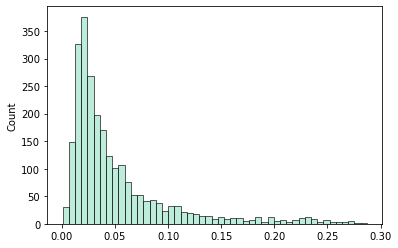

In [37]:
sns.histplot(data=colmean_input)

In [38]:
colmean_input.min()

0.0006293034

### targets

read targets

In [3]:
train_multi_targets = pp.readH5pyFile(FP_MULTIOME_TRAIN_TARGETS)

In [4]:
colmean_target = train_multi_targets["block0_values"].mean(axis = 0)

In [31]:
train_multi_targets["block0_values"].shape

(105942, 23418)

In [32]:
colmean_target[:10]

array([0.49906692, 0.32367814, 0.33146796, 0.08396932, 0.03434844,
       0.25019547, 0.00465303, 0.10219903, 0.7860585 , 1.302035  ],
      dtype=float32)

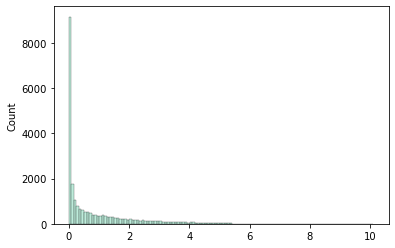

In [17]:
sns.histplot(data=colmean_target)

In [6]:
(colmean_target <= 0.25).sum()/colmean_target.shape[0]

0.5109317618925613

In [7]:
idx_zero =  np.where(colmean_target <= 0.25)[0]

In [8]:
idx_non_zero = np.where(colmean_target > 0.25)[0]

In [35]:
# train_multi_targets["axis0"][colmean_target <= 0.25]
train_multi_targets["axis0"][idx_non_zero]

array([b'ENSG00000245105', b'ENSG00000166535', b'ENSG00000184389', ...,
       b'ENSG00000198205', b'ENSG00000198455', b'ENSG00000203995'],
      dtype='|S15')

In [9]:
targets_non_zero = train_multi_targets['block0_values'][:,idx_non_zero]
targets_non_zero

array([[0.      , 0.      , 0.      , ..., 5.583255, 0.      , 4.893861],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 5.107832],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 4.871117, 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 5.659341, 0.      , 0.      ]],
      dtype=float32)

In [18]:
targets_non_zero.shape

(105942, 11453)

kmeans

In [21]:
targets_non_zero.T.shape

(11453, 105942)

In [19]:
from sklearn.cluster import KMeans
km = KMeans(
    init="random",
    n_clusters= 100,
    n_init=10,
    max_iter=300,
    random_state=42
    )

In [ ]:
km.fit(targets_non_zero.T)

shuchen's result

In [8]:
import joblib

model = joblib.load("sampledData/train_multi_targets_kmeans.m")

/Users/zyxu/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator KMeans from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.



In [5]:
response1 =  model.cluster_centers_[0,:]


In [6]:
resTotal = []
for i in tqdm(range(0,228942,10000)):
    res = []
    j = i+10000
    if j >= 228942:
        j = 228941
    train_multi_inputs = pp.readH5pyFile_cols(FP_MULTIOME_TRAIN_INPUTS, i, j)
    for colId in range(train_multi_inputs['matrix'].shape[1]):
        cor = np.corrcoef(train_multi_inputs['matrix'][:,colId], response1)
        res.append(cor[0,1])
    pd.DataFrame(res).to_csv(f"response1_corr_{i}.csv.gz", index=False, compression='gzip')
    resTotal = resTotal + res

  0%|          | 0/23 [00:00<?, ?it/s]/Users/zyxu/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/Users/zyxu/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide

100%|██████████| 23/23 [37:16<00:00, 97.24s/it]


In [14]:
pd.DataFrame(resTotal).to_csv(f"response1_corr_Total.csv.gz", index=False, compression='gzip')

In [18]:
a = pd.read_csv("corr/response1_corr_220000.csv.gz", compression='gzip')

In [19]:
len(resTotal)

228941

In [20]:
len(a)

8941

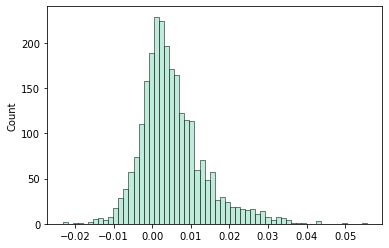

In [16]:
sns.histplot(data=res)

### partial PCA

In [9]:
# test_multi = SingleCellDataset_test(FP_MULTIOME_TEST_INPUTS,testresponse =20)
test_multi = SingleCellDataset(FP_MULTIOME_TRAIN_INPUTS)
testloader_multi = DataLoader(test_multi, batch_size=64)
# train_multi = SingleCellDataset_test(FP_MULTIOME_TRAIN_INPUTS,FP_MULTIOME_TRAIN_TARGETS,testresponse =20)
train_multi = SingleCellDataset(FP_MULTIOME_TRAIN_INPUTS,FP_MULTIOME_TRAIN_TARGETS)
trainloader_multi = DataLoader(train_multi, batch_size=64)

In [10]:
len(test_multi)/1024 - len(testloader_multi)

-1552.541015625

In [11]:
# from sklearn.cluster import MiniBatchKMeans
# km = MiniBatchKMeans(n_clusters=100,
#                     random_state=0,
#                     batch_size=256)
    
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=10, 
                    batch_size=64)

In [12]:
i = 0
# cell_ids, inputs, targets = next(iter(trainloader_multi))
for cell_ids, inputs, targets in tqdm(trainloader_multi):
    ## first filter the cells to be estimated
    ipca.fit(inputs)
    i += 1
    if i>=3:
        break

  0%|          | 2/1656 [00:06<1:33:05,  3.38s/it]


In [13]:
ipca.components_.shape

(10, 228942)

In [14]:
ipca.get_params()

{'batch_size': 64, 'copy': True, 'n_components': 10, 'whiten': False}

In [15]:
# save the model to disk
filename = 'test_ipca.sav'


In [16]:
joblib.dump(ipca, f"sampledData/{filename}")

['sampledData/test_ipca.sav']

In [17]:
ipca2 = joblib.load("sampledData/test_ipca.sav")

In [20]:
ipca2.components_.shape

(10, 228942)

In [24]:
np.square(ipca.components_ - ipca2.components_).sum()

0.0

In [31]:
cell_ids, inputs, targets = next(iter(trainloader_multi))

In [46]:
pca1 = ipca.transform(np.ones((2,228942)))

ValueError: operands could not be broadcast together with shapes (2,228942) (2,) 

In [16]:
pca1.shape

(2, 100)

In [47]:
pca2 = np.matmul(np.ones((2,228942)),ipca.components_.T)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 228942)

In [24]:
pca2.shape

(2, 100)

In [29]:
pca2[:10,:10]

array([[ 2.57548886e+02,  2.73823071e+00,  2.56477243e+01,
         1.11150709e+01, -2.03211882e+00, -4.95940319e+00,
        -1.67798656e-01, -2.94611642e+01,  1.93538095e+01,
         7.31584473e+00],
       [ 2.57548886e+02,  2.73823071e+00,  2.56477243e+01,
         1.11150709e+01, -2.03211882e+00, -4.95940319e+00,
        -1.67798656e-01, -2.94611642e+01,  1.93538095e+01,
         7.31584473e+00]])

In [30]:
pca1[:10,:10]

array([[ 2.28853910e+02,  2.03343046e+00,  2.62105341e+01,
         1.06443599e+01, -2.06633664e+00, -5.18126803e+00,
        -1.07902241e-01, -2.89377968e+01,  1.86520177e+01,
         6.73895395e+00],
       [ 2.28853910e+02,  2.03343046e+00,  2.62105341e+01,
         1.06443599e+01, -2.06633664e+00, -5.18126803e+00,
        -1.07902241e-01, -2.89377968e+01,  1.86520177e+01,
         6.73895395e+00]])

In [26]:
import numpy as np
from sklearn.decomposition import IncrementalPCA
X = np.array([[-1, -1], [-2, -1], [-3, -2],
              [1, 1], [2, 1], [3, 2]])
ipca = IncrementalPCA(n_components=2, batch_size=3)
ipca.fit(X)

ipca.transform(X) 

array([[-1.38340578, -0.2935787 ],
       [-2.22189802,  0.25133484],
       [-3.6053038 , -0.04224385],
       [ 1.38340578,  0.2935787 ],
       [ 2.22189802, -0.25133484],
       [ 3.6053038 ,  0.04224385]])

In [27]:
np.matmul(X, ipca.components_.T)

array([[-1.38340578, -0.2935787 ],
       [-2.22189802,  0.25133484],
       [-3.6053038 , -0.04224385],
       [ 1.38340578,  0.2935787 ],
       [ 2.22189802, -0.25133484],
       [ 3.6053038 ,  0.04224385]])

In [43]:
y = np.ones((2,2))

In [44]:

ipca.transform(y) 

array([[1.38340578, 0.2935787 ],
       [1.38340578, 0.2935787 ]])

In [45]:
np.matmul(y, ipca.components_.T)

array([[1.38340578, 0.2935787 ],
       [1.38340578, 0.2935787 ]])

In [1]:
DATA_DIR = ""
# FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

# FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
# FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
os.path.join(DATA_DIR,"train_multi_inputs.h5")

'train_multi_inputs.h5'